# WAF 2023
Analysis of passenger airline timeliness and determinants of on-time performance.

In [26]:
# load relevant libraries
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date
from sklearn_pandas import gen_features, DataFrameMapper


def getSeason(data):
    """
    A function which takes a row in a pandas dataframe, extracts the date of the flight, 
    and converts it to the appropriate season in the year (based on North American hemisphere)

    Parameters
    ----------
    data (pd.DataFrame) : an observation from a pandas dataframe that contains the month and day as int types under `MONTH` and `DAY_OF_MONTH`, respectively

    Returns
    -------
    season (str) : one of 'winter', 'spring', 'summer', or 'autumn', the season the input date is associated with
    """
    #spring runs from March 1 to May 31;
    #summer runs from June 1 to August 31;
    #fall (autumn) runs from September 1 to November 30; and
    #winter runs from December 1 to February 28 (February 29 in a leap year).


    year = 2000 # set to 2000 to support Feb. 29
    seasons = [
        ("winter", date(year, 1, 1), date(year, 2, 29)),
        ("winter", date(year, 12, 1), date(year, 12, 31)),
        ("spring", date(year, 3, 1), date(year, 5, 31)),
        ("summer", date(year, 6, 1), date(year, 8, 31)),
        ("autumn", date(year, 9, 1), date(year, 11, 30)),
    ]
    curr_date = date(year, data["MONTH"], data["DAY_OF_MONTH"])


    for season in seasons:
        if season[1]<= curr_date and curr_date <= season[2]:
            return season[0]

In [2]:
# load the data
flights_original_df = pd.read_csv(
    "./Data/fa23_datachallenge.csv",
    header=0
)
print(f"The data has shape: {flights_original_df.shape}")
flights_original_df.head(10)

The data has shape: (890644, 49)


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_NAME,ORIGIN,ORIGIN_CITY_NAME,...,AWND,PSUN,TSUN,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS
0,6,8,6,AA,N186US,1216,11298,Dallas Fort Worth Regional,DFW,"Dallas/Fort Worth, TX",...,6.04,NaN,NaN,25390.0,76419.0,12632.0,2907365.0,11744595.0,0.000098,0.000177
1,5,19,7,OO,N445SW,3643,11823,NaN,FWA,"Fort Wayne, IN",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,18,3,MQ,N226NN,3303,11298,Dallas Fort Worth Regional,DFW,"Dallas/Fort Worth, TX",...,3.36,NaN,NaN,25322.0,26721.0,5416.0,2907365.0,1204766.0,0.000348,0.000107
3,1,2,3,YX,N408YX,4697,10785,NaN,BTV,"Burlington, VT",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,21,4,DL,N986AT,2639,14771,San Francisco International,SFO,"San Francisco, CA",...,7.61,NaN,NaN,13989.0,84142.0,1146.0,1908862.0,12460183.0,0.000144,0.000149
5,10,25,5,WN,N206WN,8,11259,Dallas Love Field,DAL,"Dallas, TX",...,15.88,NaN,NaN,6261.0,115051.0,5727.0,673221.0,13382999.0,0.000062,0.000099
6,2,1,5,AA,N937AN,168,12889,McCarran International,LAS,"Las Vegas, NV",...,3.80,NaN,NaN,11500.0,70199.0,1059.0,1903352.0,11744595.0,0.000098,0.000177
7,9,15,7,WN,N224WN,4551,14122,Pittsburgh International,PIT,"Pittsburgh, PA",...,3.80,NaN,NaN,4113.0,107436.0,732.0,385767.0,13382999.0,0.000062,0.000099
8,10,29,2,F9,N205FR,244,11292,Stapleton International,DEN,"Denver, CO",...,12.30,NaN,NaN,22355.0,12581.0,2616.0,2743323.0,1857122.0,0.000116,0.000007
9,2,19,2,DL,N887DN,505,14869,Salt Lake City International,SLC,"Salt Lake City, UT",...,10.74,NaN,NaN,8345.0,67273.0,3086.0,1065782.0,12460183.0,0.000144,0.000149


## Exploratory Data Analysis
[...]

Do some EDA First before dropping a bunch of shit



### Features to drop due to data leakage or mutual information
* `TAIL_NUM` - Unique number that identifies each aircraft
* `OP_CARRIER_FL_NUM` - Flight number 
* `ORIGIN_AIRPORT_ID` - A unique identifier for origin airport, numeric, expresses the same information as `ORIGIN`
* `ORIGIN_AIRPORT_NAME` - The english name of the origin airport, expresses the same information as `ORIGIN`
* `ORIGIN_CITY_NAME` - The english name of the airport's city, expresses the same information as `ORIGIN`
* `DEST_AIRPORT_ID` - A unique identifier for destination airport, numeric, expresses the same information as `DEST`
* `DEST_CITY_NAME` - The english name of the destination airport, expresses the same information as `DEST`
* `DEP_TIME` - In predicting, we will have the planned departure time but not the actual departure time, so adding this feature would leak information to the model about the future, we should drop this
* `ARR_TIME` - In predicting, we will have planned arrival time but not the actual arrival time, so adding this feature would leak information to the model about the future, we should drop this
* `ARR_DELAY_NEW` we won't know the arrival delay time at the time of prediction
* Drop all the delay types as we won't have this info ahead of the prediction moment.


### Features to drop due to feature engineering
* Using `DEP_TIME_BLK` instead of `CRS_DEP_TIME` and `ARR_TIME_BLK` instead of `CRS_ARR_TIME`, respectively, will allow us to encode the same information while reducing the dimensionality of feature space, representing the departure and arrival times more meaningfully
* Drop all observations for which the flight is cancelled, using the `CANCELLED` flag variable
* Drop `CANCELLATION_CODE` as well
* Drop `DISTANCE_GROUP` a binned representation of the flight distance. Though this might be helpful in some cases, there is a significant amount of information that is lost by using this over `DISTANCE`; also, we don't know what the cutoffs for the bins are, which could be problematic and introduce bias into our analysis
* Drop `AIRLINE_AIRPORT_FLIGHTS_MONTH` if it is highly correlated with `AIRPORT_FLIGHTS_MONTH` and `AIRLINE_FLIGHTS_MONTH`


### Data Cleaning
To begin, we take a few data cleaning steps based on the problem context and what we know about the data after some inspection in its raw form:
1. **We ensure there are no duplicates** in the data, and if there are any, we drop them.
2. After some quick inspection, it appears that flights with the `CANCELLED` flag show **no record of a delay**, these are not relevant for our analysis so we drop these observations as welll as related columns.
3. There are a number of features that: 1) Should not have a realationship with the target variables we're concerned with (e.g., `TAIL_NUM` contains a unique number that identifies specific aircraft, anticipate the specific aircraft in use should not be a driver of delays); or 2) Very clearly contain information that is contained within other features (e.g., `ORIGIN_AIRPORT_ID` contains a unique identifier for each airport which serves the same purpose as the codes in `ORIGIN`). We drop these columns as well.

In [40]:
# given the nature of the data, there shouldn't be any duplicated values so we double check and drop if there are
flights_cleaned_df = flights_original_df.drop_duplicates()

# lets drop all cancelled flights, these flights aren't relevant to our analysis
flights_cleaned_df = flights_cleaned_df.loc[flights_original_df.CANCELLED != 1, :]
flights_cleaned_df = flights_cleaned_df.drop(
    labels=["CANCELLED", "CANCELLATION_CODE"],
    axis=1
)

# lets drop all the features whose information is encoded in a related but different feature in the data
flights_cleaned_df = flights_cleaned_df.drop(
    labels=[
        "TAIL_NUM", 
        "OP_CARRIER_FL_NUM",
        "ORIGIN_AIRPORT_ID",
        "ORIGIN_AIRPORT_NAME",
        "ORIGIN_CITY_NAME",
        "DEST_AIRPORT_ID",
        "DEST_CITY_NAME"
    ],
    axis=1
)

# finally, lets drop features that we won't have access to if making real-time predictions on new data
# using these will leak information about the future to any models we build, likely inflating perfomance
flights_cleaned_df = flights_cleaned_df.drop(
    labels=[
        "DEP_TIME",
        "ARR_TIME",
        "ARR_DELAY_NEW",
        "CRS_ELAPSED_TIME",
        "ACTUAL_ELAPSED_TIME"
    ],
    axis=1
)

# check out the shape of our data again
print(f"The data has shape: {flights_cleaned_df.shape}")

The data has shape: (874401, 35)


### Exploratory Visualizations

Next we want to get an understanding of the distribution of null values across are remaining features. Ideally this helps inform whether we need imputation methods


Lets also get an idea of how the date relates to delay


Lets get an idea of how delay reasons...
In particular, what is the most common reason for delay - which reason results in the most severe delays
Not a key contributing factor given we are less concerned with arrival time delay and more concerned with departure time delay.

Compare distribution of grouped distance data vs. regular distance data

In [41]:
flights_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 874401 entries, 0 to 890643
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   MONTH                          874401 non-null  int64  
 1   DAY_OF_MONTH                   874401 non-null  int64  
 2   DAY_OF_WEEK                    874401 non-null  int64  
 3   OP_UNIQUE_CARRIER              874401 non-null  object 
 4   ORIGIN                         874401 non-null  object 
 5   DEST                           874401 non-null  object 
 6   CRS_DEP_TIME                   874401 non-null  int64  
 7   DEP_DELAY_NEW                  874401 non-null  float64
 8   DEP_DEL15                      874401 non-null  float64
 9   DEP_TIME_BLK                   874401 non-null  object 
 10  CRS_ARR_TIME                   874401 non-null  int64  
 11  ARR_TIME_BLK                   874401 non-null  object 
 12  DISTANCE                       8744

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categ

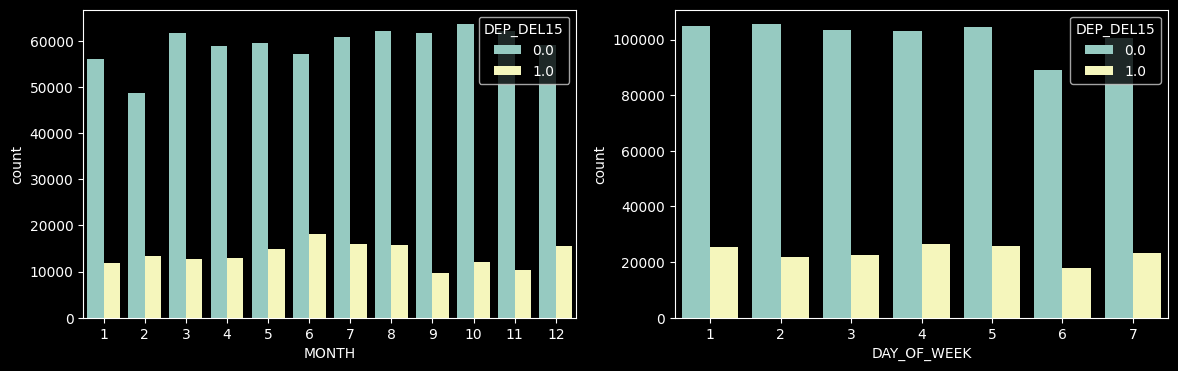

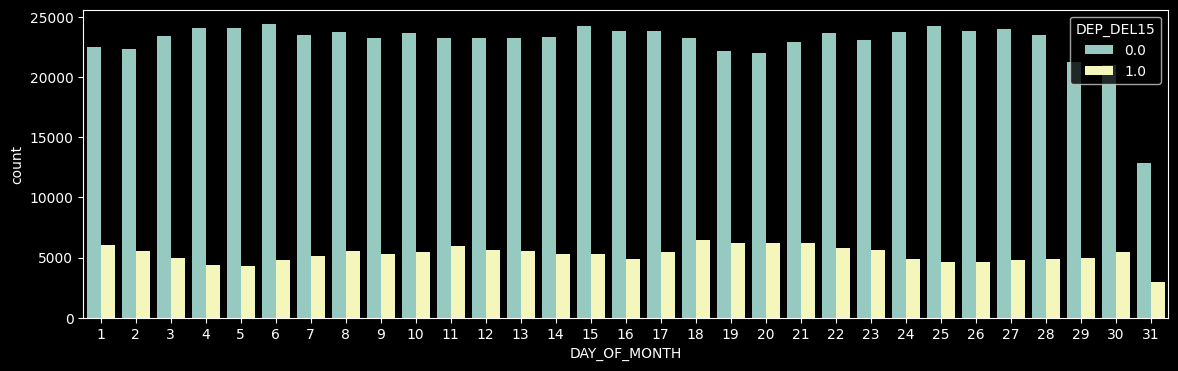

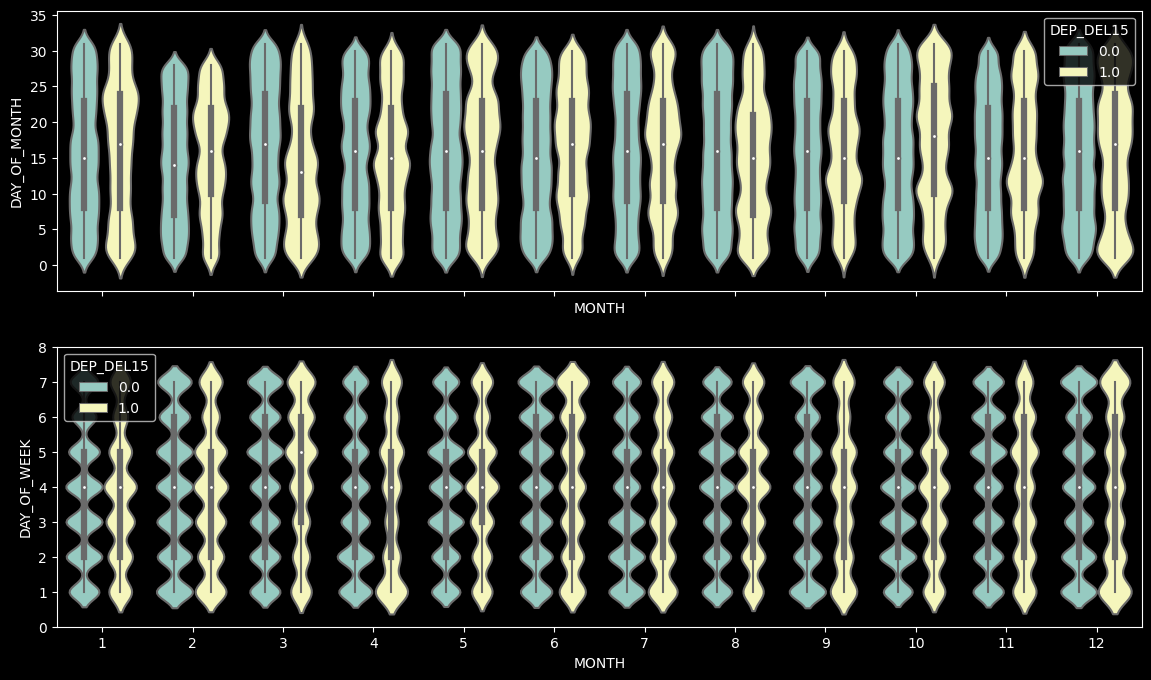

In [10]:
# let's understand the relationship between the target 
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(14,4))
sns.countplot(
    data=flights_cleaned_df,
    x="MONTH",
    hue="DEP_DEL15",
    ax=axs[0]
);
sns.countplot(
    data=flights_cleaned_df,
    x="DAY_OF_WEEK",
    hue="DEP_DEL15",
    ax=axs[1]
);

fig, axs = plt.subplots(ncols=1,nrows=1,figsize=(14,4))
sns.countplot(
    data=flights_cleaned_df,
    x="DAY_OF_MONTH",
    hue="DEP_DEL15",
    ax=axs
);

fig, axs = plt.subplots(ncols=1,nrows=2,figsize=(14,8),sharex=True)
sns.violinplot(
    data=flights_cleaned_df,
    x="MONTH",
    y="DAY_OF_MONTH",
    hue="DEP_DEL15",
    ax=axs[0]
);

sns.violinplot(
    data=flights_cleaned_df,
    x="MONTH",
    y="DAY_OF_WEEK",
    hue="DEP_DEL15",
    ax=axs[1]
);

<Axes: >

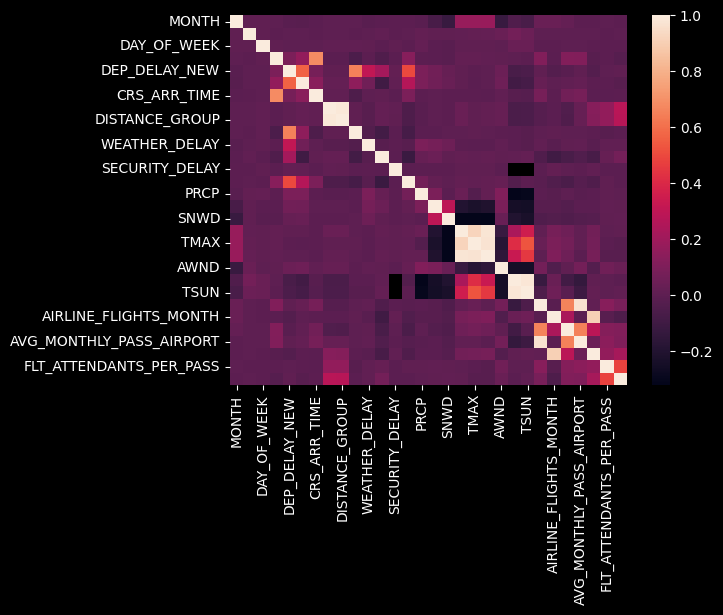

In [42]:
sns.heatmap(
    data=flights_cleaned_df.corr(numeric_only=True)
)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

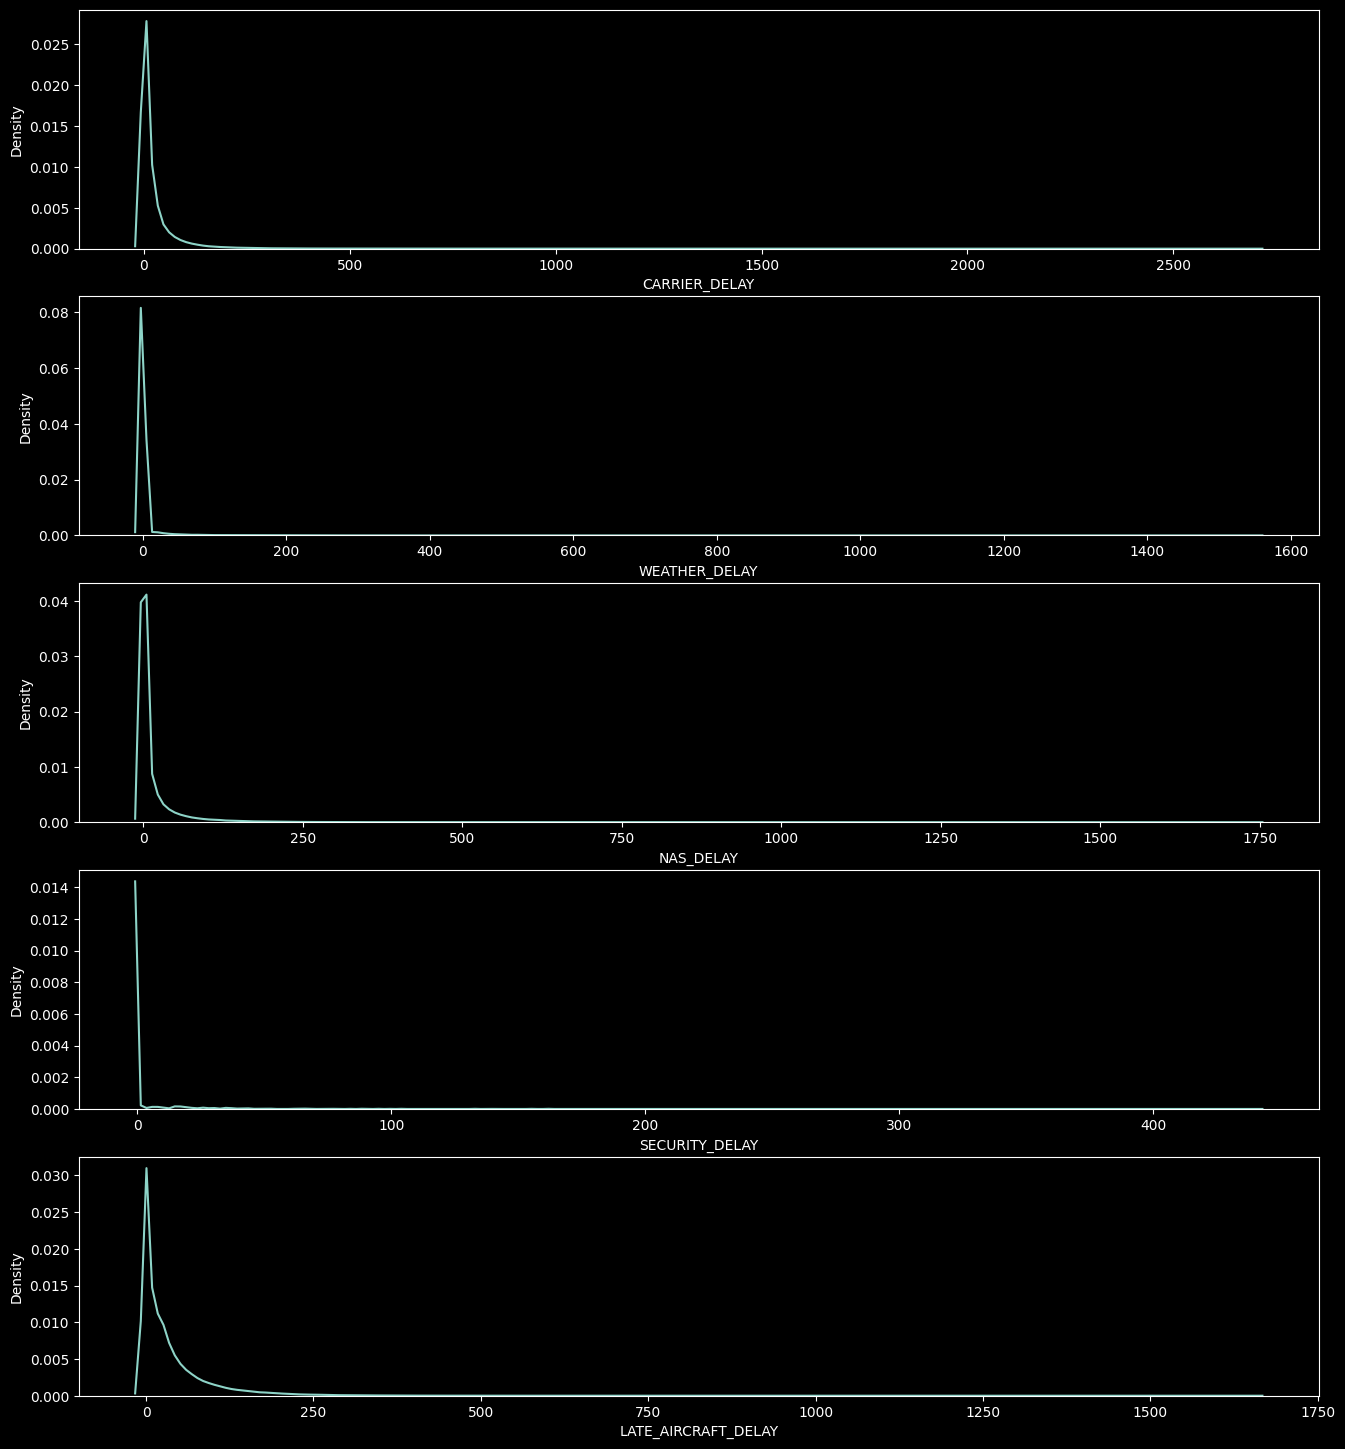

In [52]:


fig, axs = plt.subplots(ncols=1,nrows=5,figsize=(16,18))
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "CARRIER_DELAY"], ax=axs[0]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "WEATHER_DELAY"], ax=axs[1]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "NAS_DELAY"], ax=axs[2]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "SECURITY_DELAY"], ax=axs[3]);
sns.kdeplot(x=flights_cleaned_df.loc[flights_cleaned_df.DEP_DEL15==1, "LATE_AIRCRAFT_DELAY"], ax=axs[4]);

In [ ]:
flights_cleaned_df["SEASON"] = flights_cleaned_df.apply(getSeason, axis=1)
flights_cleaned_df = flights_cleaned_df.drop(
    labels=[
        "CARRIER_DELAY",
        "WEATHER_DELAY",
        "NAS_DELAY",
        "SECURITY_DELAY",
        "LATE_AIRCRAFT_DELAY",
        "MONTH",
        "DAY_OF_MONTH"
    ],
    axis=1
)

In [ ]:
palette = sns.diverging_palette(220, 20)[::5]

sns.pairplot(
    flights_cleaned_df, 
    hue="DEP_DEL15",
    dropna=True,
    palette=palette
);